In [1]:
import pandas as pd
import numpy as np
import urllib
import operator
from sklearn import preprocessing
from beautifultable import BeautifulTable
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

In [2]:
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

# Read data and divide into training and testing set.

In [3]:
bankDataURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/Active-and-Passive-Learning/master/data_banknote_authentication.txt'
bankFeatures = ['variance', 'skewness', 'curtosis', 'entropy']
bankColumnNames = bankFeatures[:]
bankColumnNames.append('class')

In [4]:
bankData = pd.read_csv(bankDataURL, names=bankColumnNames)
print('------------------------------------------------')
print('First 5 observations')
print('------------------------------------------------')
print(bankData.head())

------------------------------------------------
First 5 observations
------------------------------------------------
   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0


In [5]:
minMaxScaler = preprocessing.MinMaxScaler()
normalizedBankData = minMaxScaler.fit_transform(bankData[bankFeatures])
normalizedBankData = pd.DataFrame(normalizedBankData, columns=bankFeatures)
normalizedBankData = pd.concat([normalizedBankData, bankData['class']], axis=1)

In [6]:
bankTrainData, bankTestData = train_test_split(normalizedBankData, train_size=900)

In [7]:
print('------------------------------------------------')
print('Total train observations:', bankTrainData.shape[0])
print('First 5 train observations:')
print('------------------------------------------------')
print(bankTrainData.head())

------------------------------------------------
Total train observations: 900
First 5 train observations:
------------------------------------------------
      variance  skewness  curtosis   entropy  class
680   0.756377  0.625784  0.271962  0.826927      0
21    0.531575  0.348662  0.424662  0.687362      0
44    0.713800  0.774216  0.193524  0.821284      0
1262  0.435360  0.518544  0.217111  0.818815      1
202   0.451089  0.873327  0.064592  0.095002      0


In [8]:
print('------------------------------------------------')
print('Total test observations:', bankTestData.shape[0])
print('First 5 test observations:')
print('------------------------------------------------')
print(bankTestData.head())

------------------------------------------------
Total test observations: 472
First 5 test observations:
------------------------------------------------
      variance  skewness  curtosis   entropy  class
700   0.790970  0.741000  0.140888  0.771313      0
1369  0.237385  0.011768  0.985603  0.524755      1
502   0.652431  0.258536  0.578030  0.755440      0
1020  0.158860  0.765157  0.217258  0.179192      1
1243  0.142389  0.321253  0.676878  0.698414      1


# Passive Learning.

In [9]:
passiveTestErrors = {}
for i in range(0, 50):
    bankTrainDataCopy = bankTrainData
    sampledTrainData = pd.DataFrame()
    class0TrainData = bankTrainDataCopy.loc[bankTrainDataCopy['class'] == 0].sample(n=5)
    class1TrainData = bankTrainDataCopy.loc[bankTrainDataCopy['class'] == 1].sample(n=5)
    sampledData = pd.concat([class0TrainData, class1TrainData], axis=0)
    
    for j in range(0, 90):
        sampledTrainData = pd.concat([sampledTrainData, sampledData], axis=0)
        for rowIdx in sampledData.index:
            bankTrainDataCopy = bankTrainDataCopy.drop(index=rowIdx)
            
        CRange = np.logspace(-1, 4, 20)
        l1SVMModel = LinearSVC(penalty='l1', dual=False)
        l1Parameters = {'C':CRange}
        l1GridModel = GridSearchCV(l1SVMModel, l1Parameters, cv=KFold(10))
        
        l1GridModel = l1GridModel.fit(sampledTrainData[bankFeatures], sampledTrainData['class'])
        
        predictedTestClass = l1GridModel.predict(bankTestData[bankFeatures])
    
        testAccuracy = accuracy_score(predictedTestClass, bankTestData['class'])
        testAccuracy = round(testAccuracy, 3)
        testError = round(1 - testAccuracy, 3)
        
        if (j*10+10) in passiveTestErrors.keys():
            passiveTestErrors[j*10+10] += testError
        else:
            passiveTestErrors[j*10+10] = testError
            
        if len(bankTrainDataCopy)!=0:
            sampledData = pd.DataFrame()
            sampledData = bankTrainDataCopy.sample(10)
            
for k,v in passiveTestErrors.items():
    passiveTestErrors[k] = round(v/50, 3)

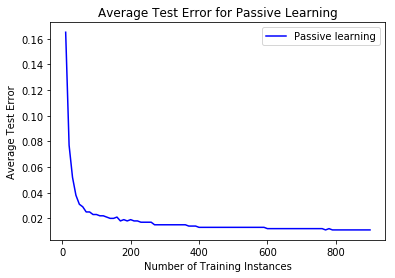

In [10]:
plt.title('Average Test Error for Passive Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.plot(passiveTestErrors.keys(), passiveTestErrors.values(), 'b', label="Passive learning")
plt.legend()
plt.show()

# Active Learning.

In [11]:
activeTestErrors = {}
for i in range(0, 50):
    bankTrainDataCopy = bankTrainData
    sampledTrainData = pd.DataFrame()
    class0TrainData = bankTrainDataCopy.loc[bankTrainDataCopy['class'] == 0].sample(n=5)
    class1TrainData = bankTrainDataCopy.loc[bankTrainDataCopy['class'] == 1].sample(n=5)
    sampledData = pd.concat([class0TrainData, class1TrainData], axis=0)
    
    for j in range(0, 90):
        sampledTrainData = pd.concat([sampledTrainData, sampledData], axis=0)
        for rowIdx in sampledData.index:
            bankTrainDataCopy = bankTrainDataCopy.drop(index=rowIdx)
            
        CRange = np.logspace(-1, 4, 20)
        l1SVMModel = LinearSVC(penalty='l1', dual=False)
        l1Parameters = {'C':CRange}
        l1GridModel = GridSearchCV(l1SVMModel, l1Parameters, cv=KFold(10))
        
        l1GridModel = l1GridModel.fit(sampledTrainData[bankFeatures], sampledTrainData['class'])
        
        if len(bankTrainDataCopy)!=0:
            trainDistances = l1GridModel.decision_function(bankTrainDataCopy[bankFeatures])

            t = 0
            trainDistanceDict = {}
            for k in bankTrainDataCopy.index:
                trainDistanceDict[k] = round(abs(trainDistances[t]), 3)
                t += 1

            sortedTrainDistances = sorted(trainDistanceDict.items(), key=operator.itemgetter(1))

            sampledData = pd.DataFrame()
            for k in range(0, 10):
                idx = sortedTrainDistances[k][0]
                row = bankTrainDataCopy.loc[idx]
                sampledData = sampledData.append([row])
            sampledData = pd.DataFrame(sampledData)
        
        predictedTestClass = l1GridModel.predict(bankTestData[bankFeatures])
    
        testAccuracy = accuracy_score(predictedTestClass, bankTestData['class'])
        testAccuracy = round(testAccuracy, 3)
        testError = round(1 - testAccuracy, 3)
        
        if (j*10+10) in activeTestErrors.keys():
            activeTestErrors[j*10+10] += testError
        else:
            activeTestErrors[j*10+10] = testError
            
for k, v in activeTestErrors.items():
    activeTestErrors[k] = round(v/50, 3)

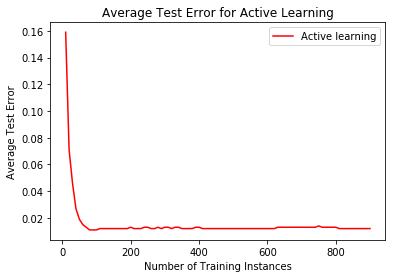

In [12]:
plt.title('Average Test Error for Active Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.plot(activeTestErrors.keys(), activeTestErrors.values(), 'r', label="Active learning")
plt.legend()
plt.show()

# Plot average test errors for Active and Passive Learning.

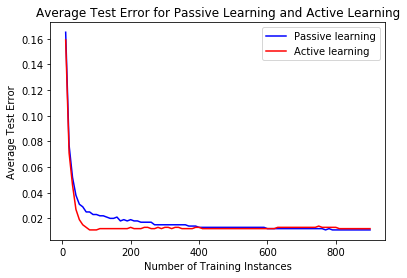

In [13]:
plt.title('Average Test Error for Passive Learning and Active Learning')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.plot(passiveTestErrors.keys(), passiveTestErrors.values(), 'b', label="Passive learning")
plt.plot(activeTestErrors.keys(), activeTestErrors.values(), 'r', label="Active learning")
plt.legend()
plt.show()

The average test error decreases rapidly for both active learning and passive learning as the number of training instances increases.